In [1]:
%matplotlib inline
import networkx as nx
import csv
import re
import pandas as pd
import numpy as np
import statistics
from statistics import StatisticsError
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD
import itertools
from sklearn import mixture


def L1 (x,y):
    dist = 0
    if len(x)==len(y):
        for i in range(len(x)):
            dist += math.fabs(x[i]-y[i])
        return(dist)
    else:
        print('vectors must be equal length for L1')
        return (None)


In [2]:
#!
# This code here makes the nx.Graph
G=nx.Graph()

m=0 # these two counters 
n=0 # arn't important

with open('training.1600000.processed.noemoticon.csv', encoding='latin-1') as f_in:
    for line in f_in: 
        lineX = list(csv.reader(line, skipinitialspace=True))
        G.add_node(lineX[8][0])
        if '@' in lineX[10][0]:
            m+=1
            for t in re.split('[^a-zA-Z\_\@]', lineX[10][0]):
                if t!='' and t[0]=='@' and t!='@':
                    G.add_edge(lineX[8][0],t[1:])
                    n+=1
        if n%100000==0:
            print(n)
print(nx.number_of_nodes(G))

100000
100000
100000
100000
100000
100000
100000
200000
200000
300000
300000
400000
500000
600000
700000
889334


In [3]:
# Finding the largest connected_component
LargestCC = max(nx.connected_component_subgraphs(G), key=len) # largest connected component
print(nx.number_of_nodes(LargestCC))
del G

339766


In [5]:
#!
# removes self-loops from the graph, this is needed to get nx.k_core
LargestCC.remove_edges_from(LargestCC.selfloop_edges())

core7 = nx.k_core(LargestCC,7)
del LargestCC

In [6]:
# find the fiedler vector, and use it to partition the graph

f = nx.fiedler_vector(core7)
s = np.zeros(len(f),dtype='int')
s[f>0]=1

# this is the positions we will use for each graph
pos = nx.spring_layout(core7)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

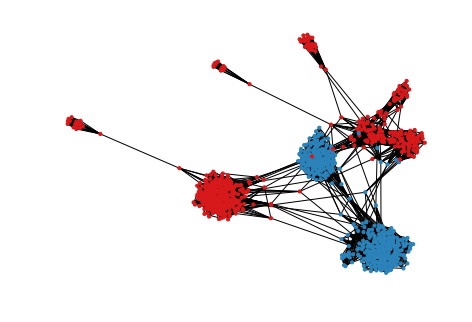

In [7]:
# draw partition
colors = ['#d7191c', '#2b83ba'] # red and blue
node_colors = [colors[s[v]] for v in range(nx.number_of_nodes(core7))]
nx.draw(core7,pos=pos, node_color=node_colors,node_size=10)


In [8]:
# this makes the laplacian matrix to do the spectral clustering
L = nx.laplacian_matrix(core7).todense()
w, v = np.linalg.eig(L)
v = np.array(v)
worder = np.argsort(w)

X = v @ np.diag(w)
X = X[:,worder]

In [9]:
# based on the graph above, k=6 was chosen. k=4 was what we were taught to
# choose, because it's the "L" in the graph. Though that didn't look good,
# so I increased k to 6.
# this runs k-means for the next code
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10)
kmeans.fit_predict(X[:,1:3])
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

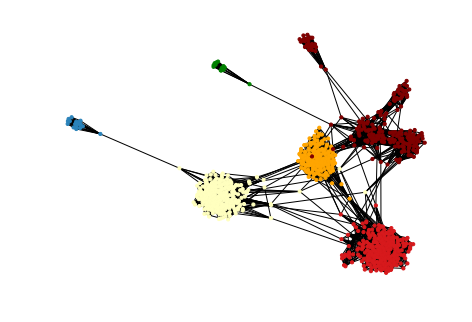

In [10]:
colors = ['#d7191c', '#ffffbf', '#2b83ba', 'green','orange','maroon']
node_colors = [colors[labels[i]] for i in range(nx.number_of_nodes(core7))]
nx.draw(core7, pos = pos, node_color=node_colors,node_size=10)

In [11]:
# Now we switch from the graphical analysis to LSA

In [12]:
#!
# this reads in the tweets
# then simply parses user ID into ID_list
# and the tweet text into TextList
TextList = []
ID_list = []
n=0
with open('training.1600000.processed.noemoticon.csv', encoding='latin-1') as f_in:
    for line in f_in:
        lineX = list(csv.reader(line, skipinitialspace=True))
        TextList.append(lineX[10][0])
        ID_list.append(lineX[8][0])
        n=n+1
        if n%100000==0:
            print(n)
print(n)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1600000


In [13]:
#!
#takes a long time
# vectorize TextList to dtm
# if you can get the snowball stemmer to work, that would be useful

vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)
dtm = vectorizer.fit_transform(TextList)
del TextList

In [14]:
#!
# compute svd of dtm
svd = TruncatedSVD(n_components=100, n_iter=4)
svdOutput = svd.fit_transform(dtm)

In [15]:
#!
# this is the model I went with for LSA

gmm = mixture.GaussianMixture(n_components=5, covariance_type='full')
gmm.fit(svdOutput[:,:15])
pred = gmm.predict(svdOutput[:,:15])

In [16]:
# this converts the GMM result from classifying tweets
# into classifying users
ID_Pred = {}
for i in range(len(ID_list)):
    ID = ID_list[i]
    if ID in ID_Pred:
        ID_Pred[ID].append(pred[i])
    else:
        ID_Pred[ID]=[pred[i]]

In [17]:
# this converts the GMM result from classifying tweets
# into classifying users
# this also classifies all users, not just core7
ID_Pred = {}
for i in range(len(ID_list)):
    ID = ID_list[i]
    if ID in ID_Pred:
        ID_Pred[ID].append(pred[i])
    else:
        ID_Pred[ID]=[pred[i]]
        
colors = ['#d7191c', '#ffffbf', '#2b83ba', 'green','orange','maroon','black']
node_colors = []
for g in core7: # classify the nodes, based off their tweets
    try:
        try: # if there is only one mode of groups, classify the user as the mode
            X = statistics.mode(ID_Pred[g])
            node_colors.append(colors[X])
        except StatisticsError: # if there is no mode, pick a tweet at random, and classify the user as that tweet's group
            node_colors.append(colors[ID_Pred[g][random.randint(0,len(ID_Pred[g])-1)]])
            
    except KeyError: # if the node never tweeted (was only tweeted at)
        node_colors.append(colors[6]) # make it black

/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

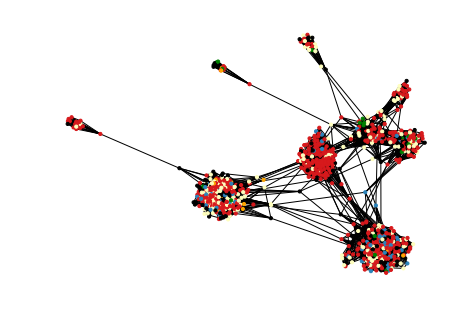

In [18]:
# draw the core7 based on LSA predictions, only to make it easier to
# compare to our spectral clustering
nx.draw(core7,pos=pos, node_color=node_colors,node_size=10)

In [20]:
#!
# this gives the top terms of each eigenvector for our LSA
# the groups aren't exactly these values, but it's similar.
# you can also plot the nodes , with these eigenvectors as the axis
# being a good way to visualize the results of LSA

terms = vectorizer.get_feature_names()

for i in range(0,10):
    top = np.argsort(svd.components_[i])
    topterms = [terms[top[f]] for f in range(30)]
    print()
    print (i, topterms)



0 ['hunggry', '302now', 'retwee', 'ctrld', 'housamz', 'øªø¹ù', 'lesnoy_chelovek', '¼í', 'laptopless', 'arturclancy', 'shoohurt', 'city_realist', 'mountain_diu', 'magicasland', 'afonin', 'mironset', 'all_lies_about', 'ðºð¾ð¼ñ', 'verysmallghost', 'rounddancer', 'ø²ù', 'beregulina', 'ð¼ð¾ð¹', 'lukashevich', '½rlich', 'dchest', 'ð¹ð½ñ', 'inviat', 'nomoretears', 'ºà']

1 ['work', 'good', 'day', 'morning', 'today', 'going', 'night', 'tomorrow', 'home', 'sleep', 'bed', 'time', 'tired', 'hope', 'ready', 'luck', 'school', 'weekend', 'getting', 'feel', 'early', 'feeling', 'long', 'week', 'sick', 'tonight', 'hours', 'great', 'happy', 'having']

2 ['work', 'just', 'going', 'want', 'quot', 'got', 'don', 'home', 'tomorrow', 'today', 'ready', 'im', 'know', 'getting', 'miss', 'wanna', 'like', 'tired', 'time', 'need', 'bored', 'think', 'hours', 'bed', 'sad', 'really', 'tonight', 'sick', 'school', 'hate']

3 ['work', 'http', 'com', 'day', 'twitpic', 'good', 'morning', 'today', 'plurk', 'tomorrow', 'tin